# Simple decision rules give high performance for detecting social bots on benchmark datasets

Analysis of benchmark datasets for bot detection.

## Setup

In [1]:
import bson
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator
import pandas as pd
import time
import importlib

In [2]:
from data_accessor import load_twibot, load_bot_repo_dataset, load_cresci, load_cresci2017, load_cresci2015, load_caverlee, load_emd, load_pan19, load_cresci2017_tweets, load_cresci2015_tweets, load_midterm, load_gilani_derived_bands, load_yang, load_yang_tweets, load_cresci_stock_tweets, tweets_to_countvectorized_df
from preprocess import drop_and_one_hot, extract_users, load_json, preprocess_users, COLUMNS_TO_DROP, DUMMY_COLUMNS
from fit_and_score import fit, score, fit_and_score, kfold_cv, analyze_bot_repo_dataset, analyze_bot_repo_dataset_full, train_test_fit_and_score, nonnumeric, mdi_feature_importance, permutation_feature_importance, plot_metrics, calculate_accuracy


In [3]:
PROJ_PATH = "/nfs/sloanlab003/projects/bot_ensemble_proj/bot-detection"


## Load datasets and calculate scores

In [4]:
kantepe_path = PROJ_PATH + "/data/kantepe-2017/tweet.bson"

with open(kantepe_path,'rb') as f:
    data = bson.decode_all(f.read())
    kantepe = pd.DataFrame(data)

NameError: name 'PROJ_PATH' is not defined

In [18]:
kantepe.head()

,Unnamed: 0,_id,currentTTs,legacyTTs,freshTTs,counts,timeStamp
0,0,58bfd6d350837b5591a2d71d,"['#kadıni̇sterse', 'seda sayan', '#i̇smailykdi...","['#8MartDünyaKadınlarGünü', '#PKKlılarHayırDiy...","['#kadıni̇sterse', 'seda sayan', '#i̇smailykdi...","[{'_1': '#İyiliğinAdı', '_2': 0}, {'_1': ""Resm...",1488967379682
1,1,58bfdbf350837b59a3954ed0,"['#kadıni̇sterse', 'seda sayan', '#i̇smailykdi...","['#8MartDünyaKadınlarGünü', '#PKKlılarHayırDiy...","['#kadıni̇sterse', 'seda sayan', '#i̇smailykdi...","[{'_1': '#İyiliğinAdı', '_2': 0}, {'_1': ""Resm...",1488968691394
2,2,58bfde4c50837b59a3955082,"['#kadıni̇sterse', 'seda sayan', '#i̇smailykdi...","['#kadıni̇sterse', 'seda sayan', '#i̇smailykdi...","['""kadın""', 'türkan elçi']","[{'_1': '#kadıni̇sterse', '_2': 1}, {'_1': 'se...",1488969292116
3,3,58bfe0a450837b59a39551b4,"['#kadıni̇sterse', 'seda sayan', '#i̇smailykdi...","['#kadıni̇sterse', 'seda sayan', '#i̇smailykdi...","['anadolu üniversitesi', 'ocak', 'dick advocaat']","[{'_1': '#kadıni̇sterse', '_2': 0}, {'_1': 'se...",1488969892455
4,4,58bfe2fb50837b59a39552be,"['seda sayan', 'i̇stanbul-bursa-i̇zmir', '#i̇s...","['#kadıni̇sterse', 'seda sayan', '#i̇smailykdi...","['i̇stanbul-bursa-i̇zmir', '#ülkücülerevetdiyor']","[{'_1': '#kadıni̇sterse', '_2': 0}, {'_1': 'se...",1488970491929
...,...,...,...,...,...,...,...
416,416,58c82f1450837b4c97c06c12,"['i̇stanbul film festivali', 'tugay kerimoğlu'...","['i̇stanbul film festivali', 'tugay kerimoğlu'...","['#tatlımtatlım', '#referandumi̇çinevet']","[{'_1': 'i̇stanbul film festivali', '_2': 4}, ...",1489514260842
417,417,58c8316c50837b4c97c1fccf,"['i̇stanbul film festivali', 'tugay kerimoğlu'...","['i̇stanbul film festivali', 'tugay kerimoğlu'...","['#kızımolmadan', 'srebrenîtsayê', 'hıncal ulu...","[{'_1': 'i̇stanbul film festivali', '_2': 4}, ...",1489514860868
418,418,58c833c450837b4c97c37d5f,"['i̇stanbul film festivali', 'tugay kerimoğlu'...","['i̇stanbul film festivali', 'tugay kerimoğlu'...","['fortisbet yüksekoran500tlbonus', 'gençlerbir...","[{'_1': 'i̇stanbul film festivali', '_2': 2}, ...",1489515460850
419,419,58c8361c50837b4c97c510c6,"['i̇stanbul film festivali', 'tugay kerimoğlu'...","['i̇stanbul film festivali', 'tugay kerimoğlu'...","['#tercihimizevetçünkü', 'gazimagusa ülküocakl...","[{'_1': 'i̇stanbul film festivali', '_2': 2}, ...",1489516060867


## Profile data

In [4]:
# Twibot
twibot_df, twibot_one_hot, twibot_labels = load_twibot(PROJ_PATH + "/data/Twibot-20/train.json")
twibot_test, twibot_one_hot_test, twibot_labels_test = load_twibot(PROJ_PATH + "/data/Twibot-20/test.json")
#twibot_validate, twibot_one_hot_validate, twibot_labels_validate = load_twibot(PROJ_PATH + "/data/Twibot-20/dev.json")
shared_columns = np.intersect1d(twibot_one_hot.columns, twibot_one_hot_test.columns) # Since we want to check on test set, just use common columns between train/test.
twibot_scores = []
for i in range(1, 6):
    dt_clf = fit(twibot_one_hot[shared_columns], twibot_labels, depth=i)
    scr = score(dt_clf, twibot_one_hot_test[shared_columns], twibot_labels_test, silent=True)
    twibot_scores.append(scr)
    
# botometer-feedback
bf, bf_one_hot, bf_labels = load_bot_repo_dataset(PROJ_PATH + "/data/botometer-feedback-2019_tweets.json", PROJ_PATH + "/data/botometer-feedback-2019.tsv")
botometer_feedback_scores = analyze_bot_repo_dataset(bf_one_hot, bf_labels, silent=True)

#rtbust
rtbust, rtbust_one_hot, rtbust_labels = load_bot_repo_dataset(PROJ_PATH + "/data/cresci-rtbust-2019_tweets.json", PROJ_PATH + "/data/cresci-rtbust-2019.tsv")
rtbust_scores = analyze_bot_repo_dataset(rtbust_one_hot, rtbust_labels, silent=True)

#gilani-2017
gilani, gilani_one_hot, gilani_labels = load_bot_repo_dataset(PROJ_PATH + "/data/gilani-2017_tweets.json", PROJ_PATH + "/data/gilani-2017.tsv")
gilani_scores = analyze_bot_repo_dataset(gilani_one_hot, gilani_labels, silent=True)

#gilani-2017 with derived features from orginal paper
gilani_derived_dfs, gilani_derived_labels = load_gilani_derived_bands(PROJ_PATH + f"/data/gilani_derived/classification_processed/")
gilani_derived_scores = [analyze_bot_repo_dataset(gilani_derived_df, gilani_derived_label, silent=True) for gilani_derived_df, gilani_derived_label in zip(gilani_derived_dfs, gilani_derived_labels)]
gilani_derived_scores_avg = [[sum([strat[depth_ind][scr_ind] for strat in gilani_derived_scores])/4 for scr_ind in range(4)] for depth_ind in range(5)]

#cresci-2017
cresci2017, cresci2017_one_hot, cresci2017_labels = load_cresci2017(PROJ_PATH + "/data/cresci-2017/{}.csv/users.csv")
cresci2017_scores = analyze_bot_repo_dataset(cresci2017_one_hot, cresci2017_labels, silent=True)

#cresci-2015
cresci2015, cresci2015_one_hot, cresci2015_labels = load_cresci2015(PROJ_PATH + "/data/cresci-2015/{}/users.csv")
cresci2015_scores = analyze_bot_repo_dataset(cresci2015_one_hot, cresci2015_labels, silent=True)

#caverlee-2011
caverlee2011, caverlee2011_labels = load_caverlee(PROJ_PATH + "/data/social_honeypot_icwsm_2011/")
caverlee2011_scores = analyze_bot_repo_dataset(caverlee2011, caverlee2011_labels, silent=True)

#cresci-stock-2018
cresci_stock, cresci_stock_one_hot, cresci_stock_labels = load_bot_repo_dataset(PROJ_PATH + "/data/cresci-stock-2018_tweets.json", PROJ_PATH + "/data/cresci-stock-2018.tsv")
cresci_stock_scores = analyze_bot_repo_dataset(cresci_stock_one_hot, cresci_stock_labels, silent=True)

Starting kfold_cv at 09/13/22 10:55:48
Finished kfold_cv at 1663080948.9309297. Execution time: 0.1723158359527588 s
Starting kfold_cv at 09/13/22 10:55:48
Finished kfold_cv at 1663080949.0591958. Execution time: 0.12801146507263184 s
Starting kfold_cv at 09/13/22 10:55:49
Finished kfold_cv at 1663080949.2049735. Execution time: 0.14545655250549316 s
Starting kfold_cv at 09/13/22 10:55:49
Finished kfold_cv at 1663080949.3421786. Execution time: 0.13671565055847168 s
Starting kfold_cv at 09/13/22 10:55:49
Finished kfold_cv at 1663080949.4777453. Execution time: 0.1352074146270752 s
Starting kfold_cv at 09/13/22 10:55:49
Finished kfold_cv at 1663080949.7552068. Execution time: 0.10145878791809082 s
Starting kfold_cv at 09/13/22 10:55:49
Finished kfold_cv at 1663080949.8572311. Execution time: 0.10179495811462402 s
Starting kfold_cv at 09/13/22 10:55:49
Finished kfold_cv at 1663080949.961632. Execution time: 0.1040811538696289 s
Starting kfold_cv at 09/13/22 10:55:49
Finished kfold_cv at 

In [6]:
midterm, midterm_one_hot, midterm_labels = load_midterm(PROJ_PATH + "/data/midterm-2018/midterm-2018_processed_user_objects.json", PROJ_PATH + "/data/midterm-2018/midterm-2018.tsv")
midterm_scores = analyze_bot_repo_dataset(midterm_one_hot, midterm_labels, kfold=False, silent=True)

In [7]:
yang, yang_one_hot, yang_labels = load_yang(PROJ_PATH + "/data/yang-2013/")
yang_scores = analyze_bot_repo_dataset(yang_one_hot, yang_labels)

Starting kfold_cv at 09/13/22 11:06:24
Finished kfold_cv at 1663081610.456925. Execution time: 26.267711400985718 s
Starting kfold_cv at 09/13/22 11:06:50
Finished kfold_cv at 1663081641.712649. Execution time: 31.25485324859619 s
Starting kfold_cv at 09/13/22 11:07:21
Finished kfold_cv at 1663081675.9665499. Execution time: 34.25303864479065 s
Starting kfold_cv at 09/13/22 11:07:55
Finished kfold_cv at 1663081713.9131567. Execution time: 37.94573521614075 s
Starting kfold_cv at 09/13/22 11:08:33
Finished kfold_cv at 1663081754.5034573. Execution time: 40.58941459655762 s


In [7]:
yang_scores

[[0.9162693890589557,
  0.5386251915960013,
  0.5796048745456696,
  0.5574301348331858],
 [0.9504553320274193,
  0.8423923196886918,
  0.5571083234511324,
  0.6692310227189523],
 [0.9531821932239775,
  0.9067450178616134,
  0.5429861616679106,
  0.6777900882351996],
 [0.953907894159717,
  0.8838956954685825,
  0.5672553466814786,
  0.690508190319375],
 [0.9566345484624061,
  0.8712265270302944,
  0.6205388120333772,
  0.7219407385820468]]

## Tweets data

In [8]:
yang_tweets, yang_tweets_labels = load_yang_tweets(PROJ_PATH + "/data/yang-2013/")
yang_tweets_scores = analyze_bot_repo_dataset(yang_tweets, yang_tweets_labels)


/home/zis/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Starting kfold_cv at 08/10/22 10:08:53
Finished kfold_cv at 1660140558.5270283. Execution time: 25.28953742980957 s
Starting kfold_cv at 08/10/22 10:09:18
Finished kfold_cv at 1660140596.9645147. Execution time: 38.43665790557861 s
Starting kfold_cv at 08/10/22 10:09:56
Finished kfold_cv at 1660140648.2149966. Execution time: 51.24950408935547 s
Starting kfold_cv at 08/10/22 10:10:48
Finished kfold_cv at 1660140711.753023. Execution time: 63.53710579872131 s
Starting kfold_cv at 08/10/22 10:11:51
Finished kfold_cv at 1660140787.9547045. Execution time: 76.2007224559784 s


In [9]:
pan19_df, pan19_labels = load_pan19(PROJ_PATH + "/data/pan19/pan19-author-profiling-training-2019-02-18/en/{}.xml", PROJ_PATH + "/data/pan19/pan19-author-profiling-training-2019-02-18/en/truth.txt")
pan19_scores = analyze_bot_repo_dataset(pan19_df, pan19_labels)


/home/zis/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Starting kfold_cv at 08/10/22 10:13:32
Finished kfold_cv at 1660140817.9247115. Execution time: 5.648428678512573 s
Starting kfold_cv at 08/10/22 10:13:37
Finished kfold_cv at 1660140825.80019. Execution time: 7.8749308586120605 s
Starting kfold_cv at 08/10/22 10:13:45
Finished kfold_cv at 1660140835.8390393. Execution time: 10.038085222244263 s
Starting kfold_cv at 08/10/22 10:13:55
Finished kfold_cv at 1660140848.0052521. Execution time: 12.165760517120361 s
Starting kfold_cv at 08/10/22 10:14:08
Finished kfold_cv at 1660140862.1972082. Execution time: 14.191092252731323 s


In [10]:
cresci2017_tweets, cresci2017_tweets_labels = load_cresci2017_tweets(PROJ_PATH + "/data/cresci-2017/{}.csv/tweets.csv")
cresci2017_tweets_scores = analyze_bot_repo_dataset(cresci2017_tweets, cresci2017_tweets_labels, kfold=False, silent=True)


/home/zis/test-sdr-bot/bot-detection/data_accessor.py:226: DtypeWarning: Columns (8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path_template.format(name), encoding='latin-1')
/home/zis/test-sdr-bot/bot-detection/data_accessor.py:226: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path_template.format(name), encoding='latin-1')
/home/zis/test-sdr-bot/bot-detection/data_accessor.py:226: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path_template.format(name), encoding='latin-1')
/home/zis/test-sdr-bot/bot-detection/data_accessor.py:226: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path_template.format(name), encoding='latin-1')
/home/zis/test-sdr-bot/bot-detection/data_accessor.py:226: DtypeWarning

In [11]:
cresci2015_tweets, cresci2015_tweets_labels = load_cresci2015_tweets(PROJ_PATH + "/data/cresci-2015/{}/tweets.csv")
cresci2015_tweets_scores = analyze_bot_repo_dataset(cresci2015_tweets, cresci2015_labels)


/home/zis/test-sdr-bot/bot-detection/data_accessor.py:226: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path_template.format(name), encoding='latin-1')
/home/zis/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Starting kfold_cv at 08/10/22 10:19:24
Finished kfold_cv at 1660141190.48295. Execution time: 26.354676485061646 s
Starting kfold_cv at 08/10/22 10:19:50
Finished kfold_cv at 1660141228.7627733. Execution time: 38.27929902076721 s
Starting kfold_cv at 08/10/22 10:20:28
Finished kfold_cv at 1660141274.1509948. Execution time: 45.38728928565979 s
Starting kfold_cv at 08/10/22 10:21:14
Finished kfold_cv at 1660141325.8346343. Execution time: 51.682714223861694 s
Starting kfold_cv at 08/10/22 10:22:05
Finished kfold_cv at 1660141383.699922. Execution time: 57.86433529853821 s


In [12]:
cresci_stock_tweets, cresci_stock_tweets_labels = load_cresci_stock_tweets(PROJ_PATH + "/data/cresci-stock-2018_tweets.json", PROJ_PATH + "/data/cresci-stock-2018.tsv", PROJ_PATH + "/data/golbeck/tweets/{}_tweets.csv")
cresci_stock_tweets_scores = analyze_bot_repo_dataset(cresci_stock_tweets, cresci_stock_tweets_labels)


/home/zis/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Starting kfold_cv at 08/10/22 10:39:12


MemoryError: Unable to allocate 14.6 GiB for an array with shape (196866, 9956) and data type int64

## Only account ids

In [13]:
varol = np.loadtxt(PROJ_PATH + "/data/varol-2017.dat", unpack=True)
kaiser = pyreadr.read_r(PROJ_PATH + '/data/kaiser/data_botometer.RData')['data_botometer']


NameError: name 'pyreadr' is not defined

# Train on one, test on another

In [8]:
datasets = [twibot_one_hot, bf_one_hot, rtbust_one_hot, gilani_one_hot, cresci2017_one_hot, cresci2015_one_hot, cresci_stock_one_hot, yang_one_hot]
labels = [twibot_labels, bf_labels, rtbust_labels, gilani_labels, cresci2017_labels, cresci2015_labels, cresci_stock_labels, yang_labels]

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def get_dataset_name(df):
    return namestr(df, globals())[0]

def train_on_one_test_on_another(train_on, train_on_labels, test_on, test_on_labels, silent=True):
    cols = ([e for e in list(train_on) if e in list(test_on)])
    #print(cols)
    scores = {
        'train_on': get_dataset_name(train_on),
        'test_on': get_dataset_name(test_on),
    }
    for i in range(1,6):
        clf, *_ = fit_and_score(train_on[cols], train_on_labels, silent=True)

        a,p,r,f = (score(clf, test_on[cols], test_on_labels, silent=True))
        #prop_bots = sum(test_on_labels)/len(test_on_labels)
        
        scores = {
            **scores, 
            f'a{i}': a,
            f'p{i}': p,
            f'r{i}': r,
            f'f{i}': f
        }
    if not silent:
        print(f"trained on: {get_dataset_name(train_on)}, tested on: {get_dataset_name(test_on)}, acc: {a:.2}, prec: {p:.2}, recall: {r:.2}, f1: {f:.2}, test bot freq: {np.round_(prop_bots,2)}")

    return scores
            

In [56]:
s = set(list(datasets[0]))
for i in range(1,len(datasets)):
    s = s.intersection(set(list(datasets[i])))
print(s)

{'followers_count', 'favourites_count', 'statuses_count'}


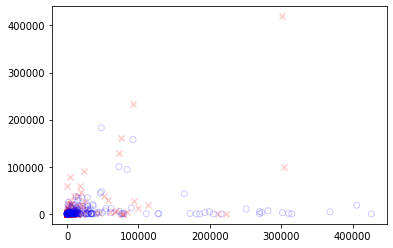

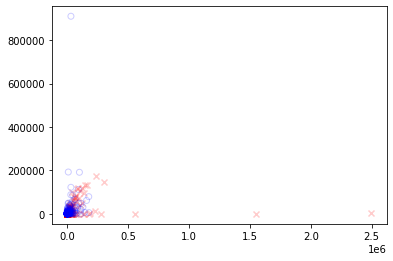

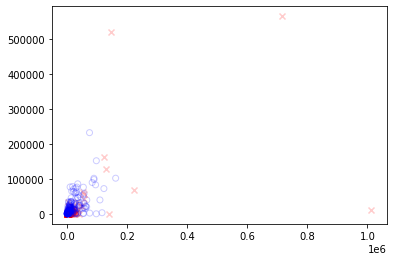

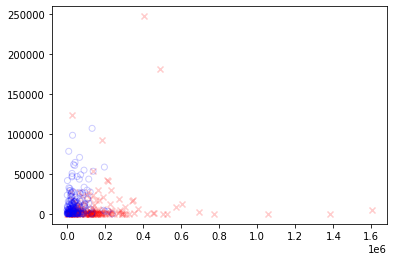

<ipython-input-128-7043d7fd11bd>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = datasets[i][pd.Series(list(labels[i])) == 1].iloc[:200]
<ipython-input-128-7043d7fd11bd>:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = datasets[i][pd.Series(list(labels[i])) == 0].iloc[:200]


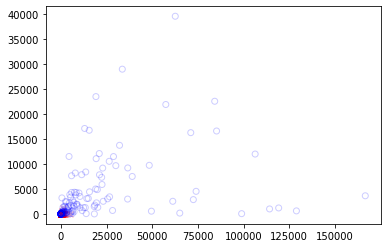

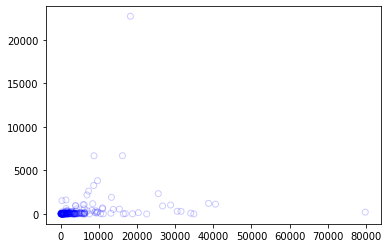

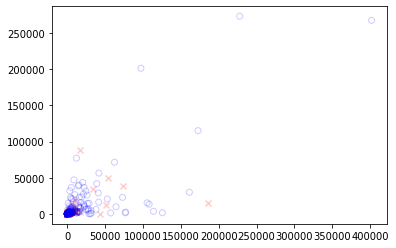

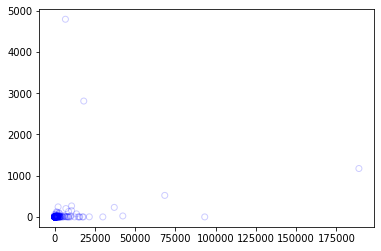

In [128]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
import random



def random_color():
    return "#{}{}{}{}{}{}".format(*(random.choice("0123456789abcdef") for _ in range(6)))

colors = [random_color() for i in range(15)]

for i in range(len(datasets)):
    try:
        fig, ax = plt.subplots()
        #plt.title("{}".format(datasets[i].__name__))

        _df = datasets[i][pd.Series(list(labels[i])) == 1].iloc[:200]

        ax.scatter(_df['statuses_count'], _df['favourites_count'],color='r', alpha = .2, marker='x')

        _df = datasets[i][pd.Series(list(labels[i])) == 0].iloc[:200]

        ax.scatter(_df['statuses_count'], _df['favourites_count'],edgecolors='b', facecolors='none', marker='o',alpha = .2)

        plt.show()
    except: continue

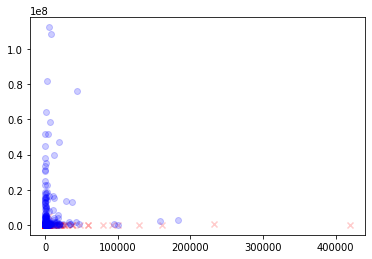

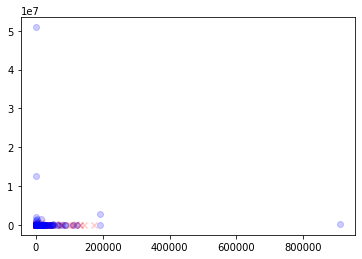

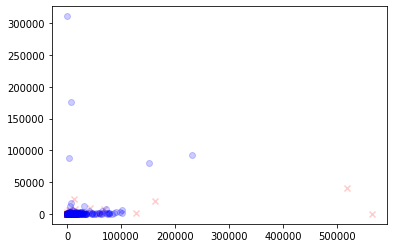

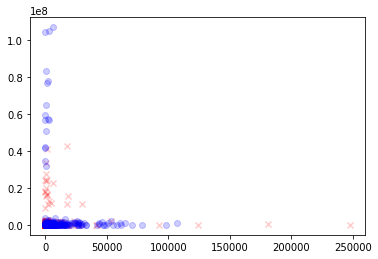

<ipython-input-118-8cf0c9ff2c85>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = datasets[i][pd.Series(list(labels[i])) == 1].iloc[:200]
<ipython-input-118-8cf0c9ff2c85>:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = datasets[i][pd.Series(list(labels[i])) == 0].iloc[:200]


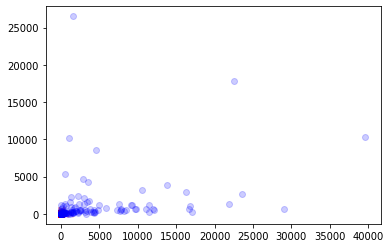

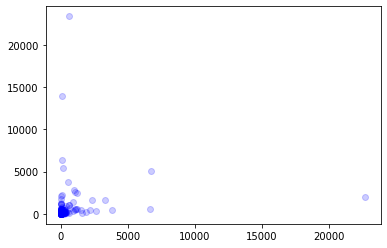

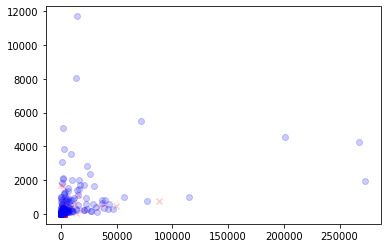

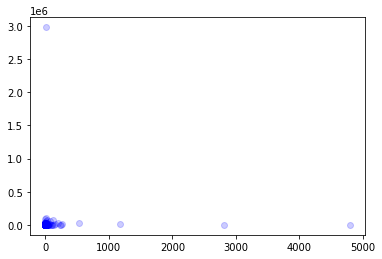

In [118]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
import random



def random_color():
    return "#{}{}{}{}{}{}".format(*(random.choice("0123456789abcdef") for _ in range(6)))

colors = [random_color() for i in range(15)]

for i in range(len(datasets)):
    try:
        fig, ax = plt.subplots()
        #plt.title("{}".format(datasets[i].__name__))

        _df = datasets[i][pd.Series(list(labels[i])) == 1].iloc[:200]

        ax.scatter(_df['favourites_count'], _df['followers_count'],color='r', alpha = .2, marker='x')

        _df = datasets[i][pd.Series(list(labels[i])) == 0].iloc[:200]

        ax.scatter(_df['favourites_count'], _df['followers_count'],color='b', alpha = .2)

        plt.show()
    except: continue

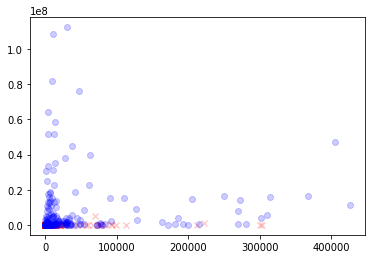

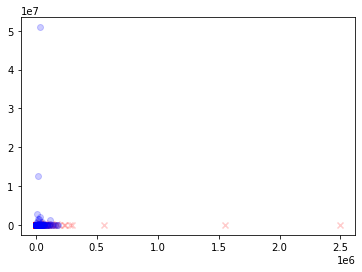

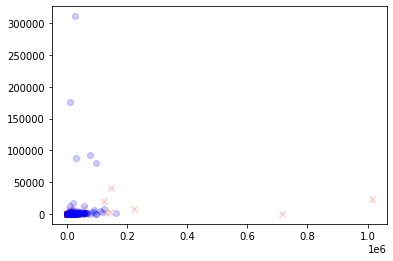

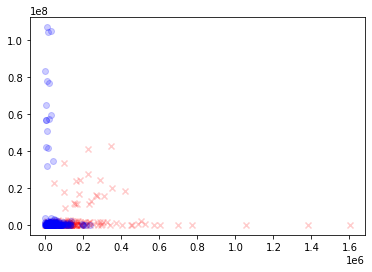

<ipython-input-117-0f8d013302f0>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = datasets[i][pd.Series(list(labels[i])) == 1].iloc[:200]
<ipython-input-117-0f8d013302f0>:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = datasets[i][pd.Series(list(labels[i])) == 0].iloc[:200]


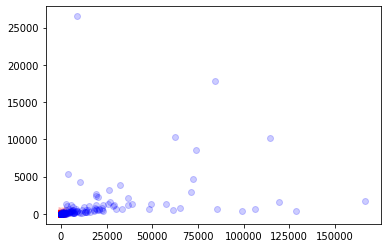

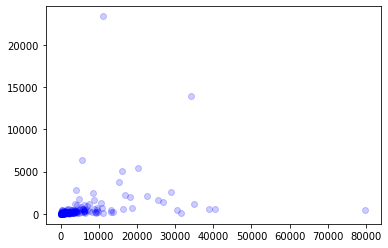

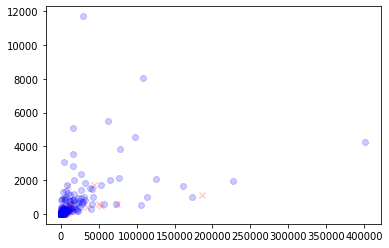

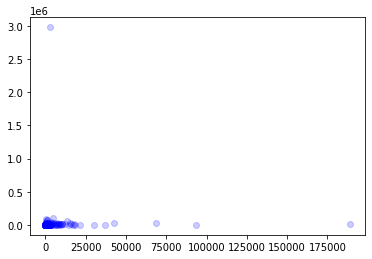

In [117]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
import random



def random_color():
    return "#{}{}{}{}{}{}".format(*(random.choice("0123456789abcdef") for _ in range(6)))

colors = [random_color() for i in range(15)]



for i in range(len(datasets)):
    try:
        fig, ax = plt.subplots()
        #plt.title("{}".format(datasets[i].__name__))

        _df = datasets[i][pd.Series(list(labels[i])) == 1].iloc[:200]

        ax.scatter(_df['statuses_count'], _df['followers_count'],color='r', alpha = .2, marker='x')

        _df = datasets[i][pd.Series(list(labels[i])) == 0].iloc[:200]

        ax.scatter(_df['statuses_count'], _df['followers_count'],color='b', alpha = .2)

        plt.show()
    except: continue

In [3]:
import plotly
import plotly.graph_objects as go




fig = go.Figure()
colors = px.colors.qualitative.Plotly
#ax.scatter(df['X'], df['Y'], df['Z'], c='skyblue', s=60)

for i in range(1):
    _df = datasets[i][pd.Series(list(labels[i])) == 0]
    #ax.scatter(_df['followers_count'], _df['friends_count'], _df['favourites_count'], c=colors[i], s=10)
    fig.add_trace(go.Scatter3d(x=_df['followers_count'], y=_df['friends_count'], z=_df['favourites_count']))
fig.show()

ModuleNotFoundError: No module named 'plotly'

In [18]:
rows = []

for train_on, train_on_labels in zip(datasets,labels):
    for test_on, test_on_labels in zip(datasets,labels):
        rows.append(train_on_one_test_on_another(train_on, train_on_labels, test_on, test_on_labels))
        
train_on_one_test_on_another_performance = pd.DataFrame(rows)     

/home/zis/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zis/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zis/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zis/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

In [20]:
train_on_one_test_on_another_performance

,train_on,test_on,a1,p1,r1,f1,a2,p2,r2,f2,...,r3,f3,a4,p4,r4,f4,a5,p5,r5,f5
0,twibot_one_hot,twibot_one_hot,0.809616,0.746705,1.000000,0.854987,0.809616,0.746705,1.000000,0.854987,...,1.000000,0.854987,0.809616,0.746705,1.000000,0.854987,0.809616,0.746705,1.000000,0.854987
1,twibot_one_hot,bf_one_hot,0.310212,0.267516,0.906475,0.413115,0.310212,0.267516,0.906475,0.413115,...,0.906475,0.413115,0.310212,0.267516,0.906475,0.413115,0.310212,0.267516,0.906475,0.413115
2,twibot_one_hot,rtbust_one_hot,0.510823,0.510264,0.985836,0.672464,0.510823,0.510264,0.985836,0.672464,...,0.985836,0.672464,0.510823,0.510264,0.985836,0.672464,0.510823,0.510264,0.985836,0.672464
3,twibot_one_hot,gilani_one_hot,0.512585,0.446809,0.500917,0.472318,0.512585,0.446809,0.500917,0.472318,...,0.500917,0.472318,0.512585,0.446809,0.500917,0.472318,0.512585,0.446809,0.500917,0.472318
4,twibot_one_hot,cresci2017_one_hot,0.759535,0.759615,0.998990,0.863011,0.759535,0.759615,0.998990,0.863011,...,0.998990,0.863011,0.759535,0.759615,0.998990,0.863011,0.759535,0.759615,0.998990,0.863011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,yang_one_hot,gilani_one_hot,0.556133,0.200000,0.006422,0.012444,0.556133,0.200000,0.006422,0.012444,...,0.006422,0.012444,0.556133,0.200000,0.006422,0.012444,0.556133,0.200000,0.006422,0.012444
60,yang_one_hot,cresci2017_one_hot,0.467984,0.989163,0.301634,0.462296,0.467984,0.989163,0.301634,0.462296,...,0.301634,0.462296,0.467984,0.989163,0.301634,0.462296,0.467984,0.989163,0.301634,0.462296
61,yang_one_hot,cresci2015_one_hot,0.775514,0.954947,0.676813,0.792176,0.775514,0.954947,0.676813,0.792176,...,0.676813,0.792176,0.775514,0.954947,0.676813,0.792176,0.775514,0.954947,0.676813,0.792176
62,yang_one_hot,cresci_stock_one_hot,0.465050,0.500000,0.000282,0.000563,0.465050,0.500000,0.000282,0.000563,...,0.000282,0.000563,0.465050,0.500000,0.000282,0.000563,0.465050,0.500000,0.000282,0.000563


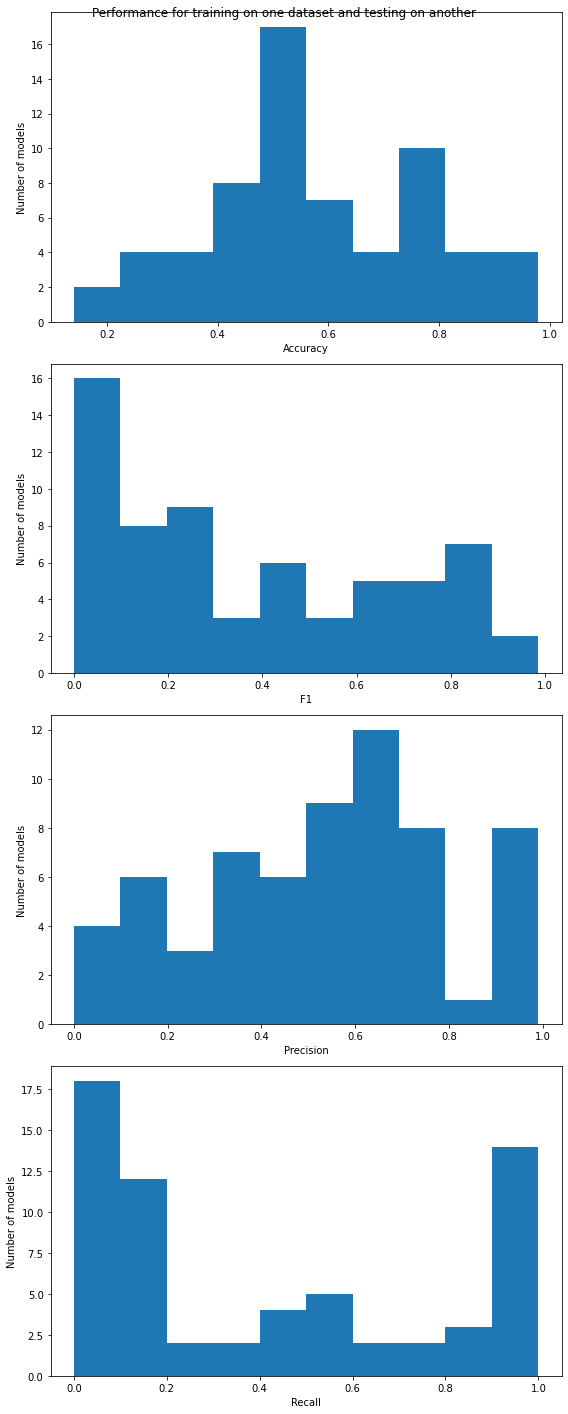

In [21]:
def hist_train_on_one_test_on_another(performance_df):
    fig, axes = plt.subplots(4, 1, figsize=(8,20))
    max_depth = 5

    accs = []
    fs = []
    precs = []
    recs = []


    for ind, row in performance_df.iterrows():
        metric_a = [row[f'a{i}'] for i in range(1,max_depth+1)]
        accs.append(max(metric_a))

        metric_f = [row[f'f{i}'] for i in range(1,max_depth+1)]
        fs.append(max(metric_f))


        metric_p = [row[f'p{i}'] for i in range(1,max_depth+1)]
        precs.append(max(metric_p))


        metric_r = [row[f'r{i}'] for i in range(1,max_depth+1)]
        recs.append(max(metric_r))


    axes[0].hist(accs)
    axes[1].hist(fs)
    axes[2].hist(precs)
    axes[3].hist(recs)


    axes[0].set_xlabel("Accuracy")
    axes[1].set_xlabel("F1")
    axes[2].set_xlabel("Precision")
    axes[3].set_xlabel("Recall")

    axes[0].set_ylabel("Number of models")
    axes[1].set_ylabel("Number of models")
    axes[2].set_ylabel("Number of models")
    axes[3].set_ylabel("Number of models")

    #axes[0].legend(loc='lower left')
    fig.suptitle("Performance for training on one dataset and testing on another")
    fig.tight_layout()
    plt.show()
    
hist_train_on_one_test_on_another(train_on_one_test_on_another_performance)

# Leave-one-dataset-out

In [168]:
cols = list(set.intersection(*map(set,[list(d) for d in datasets])))
max_depth = 5

def leave_dataset_out(i):
    
    use_datasets = datasets[:i] + datasets[i+1:]
    use_labels = labels[:i] + labels[i+1:]

    scores = {
        'left_out': get_dataset_name(datasets[i])
    }
    
    train_on = pd.concat([d[cols] for d in use_datasets])
    train_on_labels = pd.concat([pd.Series(d) for d in use_labels])
        
    test_on = datasets[i][cols]
    test_on_labels = labels[i]
    
    for j in range(1,max_depth+1):
        clf, *_ = fit_and_score(train_on[cols], train_on_labels, depth=j, silent=True)
        a,p,r,f = (score(clf, test_on[cols], test_on_labels, silent=True))
        scores = {
            **scores, 
            f'a{j}': a,
            f'p{j}': p,
            f'r{j}': r,
            f'f{j}': f
        }
    return scores


In [169]:
rows = []

for i in range(len(datasets)):
    rows.append(leave_dataset_out(i))
    
leave_one_out_scores = pd.DataFrame(rows)

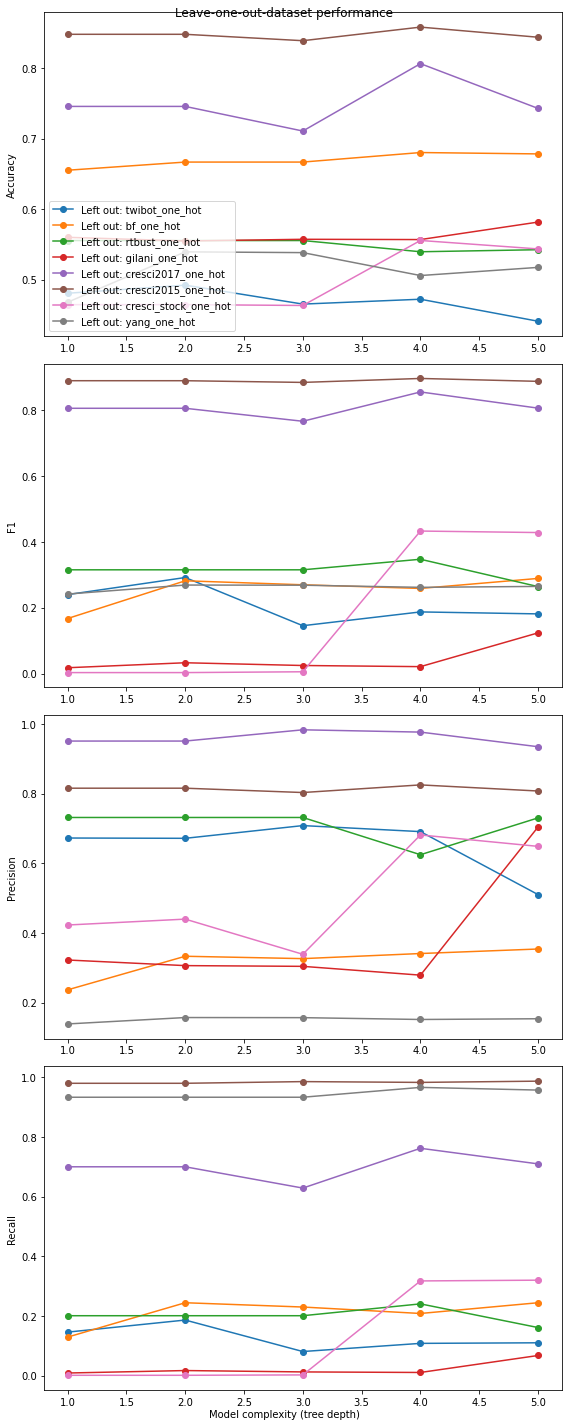

In [170]:
fig, axes = plt.subplots(4, 1, figsize=(8,20))
max_depth = 5

for ind, row in leave_one_out_scores.iterrows():
    metric_a = [row[f'a{i}'] for i in range(1,max_depth+1)]
    axes[0].plot(range(1,6), metric_a, label=f"Left out: {row['left_out']}", marker="o")
    
    metric_f = [row[f'f{i}'] for i in range(1,max_depth+1)]
    axes[1].plot(range(1,6), metric_f, label=f"Left out: {row['left_out']}", marker="o")
    
    metric_p = [row[f'p{i}'] for i in range(1,max_depth+1)]
    axes[2].plot(range(1,6), metric_p, label=f"Left out: {row['left_out']}", marker="o")
    
    metric_r = [row[f'r{i}'] for i in range(1,max_depth+1)]
    axes[3].plot(range(1,6), metric_r, label=f"Left out: {row['left_out']}", marker="o")
    
    
    axes[0].set_ylabel("Accuracy")
    axes[1].set_ylabel("F1")
    axes[2].set_ylabel("Precision")
    axes[3].set_ylabel("Recall")

axes[0].legend(loc='lower left')
fig.text(0.5, 0.0, 'Model complexity (tree depth)', ha='center')
fig.suptitle("Leave-one-out-dataset performance")
fig.tight_layout()
plt.show()

# Single-class datasets

In [25]:
# bot-wiki
botwiki_df, botwiki_one_hot, botwiki_labels = load_bot_repo_dataset(PROJ_PATH + "/data/botwiki-2019_tweets.json", PROJ_PATH + "/data/botwiki-2019.tsv")
# celebrity
celebrity_df, celebrity_one_hot, celebrity_labels = load_bot_repo_dataset(PROJ_PATH + "/data/celebrity-2019_tweets.json", PROJ_PATH + "/data/celebrity-2019.tsv")
# political-bots
political_bots_df, political_bots_one_hot, political_bots_labels = load_bot_repo_dataset(PROJ_PATH + "/data/political-bots-2019/political-bots-2019_tweets.json", PROJ_PATH + "/data/political-bots-2019/political-bots-2019.tsv")
# pronbots
pronbots_df, pronbots_one_hot, pronbots_labels = load_bot_repo_dataset(PROJ_PATH + "/data/celebrity-2019_tweets.json", PROJ_PATH + "/data/pronbots-2019.tsv")
# vendor purchased
vendor_purchased_df, vendor_purchased_one_hot, vendor_purchased_labels = load_bot_repo_dataset(PROJ_PATH + "/data/celebrity-2019_tweets.json", PROJ_PATH + "/data/vendor-purchased-2019.tsv")
# EMD
emd, emd_labels = load_emd(PROJ_PATH + '/data/EMD-2017/Twitter_dataset.arff') # Load data

## Analysis of each of the specialized classifiers in Botometer

### humans

In [76]:
caverlee2011.set_axis(['created_at', 'friends_count', 'followers_count', 'statuses_count', 'LengthfScreenName', 'LengthOfDescriptionInUserProfile'], inplace=True, axis=1)

caverlee2011_humans = caverlee2011[caverlee2011_labels.values == 0]
bf_one_hot_humans = bf_one_hot[bf_labels.values == 0]
gilani_one_hot_humans = gilani_one_hot[gilani_labels.values == 0]
rtbust_one_hot_humans = rtbust_one_hot[rtbust_labels.values == 0]
cresci_stock_one_hot_humans = cresci_stock_one_hot[cresci_stock_labels.values == 0]
midterm_one_hot_humans = midterm_one_hot[midterm_labels.values == 0]

cols = set.intersection(
    set(celebrity_one_hot.columns),
    set(bf_one_hot_humans.columns),
    set(caverlee2011_humans.columns),
    set(gilani_one_hot_humans.columns),
    set(cresci_stock_one_hot_humans.columns),
                       )

human_df = pd.concat([
    caverlee2011_humans[cols], 
    bf_one_hot_humans[cols],
    celebrity_one_hot[cols],
    gilani_one_hot_humans[cols],
    cresci_stock_one_hot_humans[cols],
    celebrity_one_hot[cols]
], axis=0)

<ipython-input-76-2874a7eeb05e>:19: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  caverlee2011_humans[cols],
<ipython-input-76-2874a7eeb05e>:20: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  bf_one_hot_humans[cols],
<ipython-input-76-2874a7eeb05e>:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  celebrity_one_hot[cols],
<ipython-input-76-2874a7eeb05e>:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  gilani_one_hot_humans[cols],
<ipython-input-76-2874a7eeb05e>:23: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cresci_stock_one_hot_humans[cols],
<ipython-input-76-2874a7eeb05e>:24: FutureWarning: Passing a set as an indexer is deprecated and will ra

In [77]:
caverlee2011_humans

,created_at,friends_count,followers_count,statuses_count,LengthfScreenName,LengthOfDescriptionInUserProfile
0,1.152819e+09,510,350,3265,10,34
1,1.152994e+09,304,443,4405,7,156
2,1.153067e+09,45,73,725,6,37
3,1.153366e+09,211,230,211,7,0
4,1.153938e+09,7346,7244,11438,8,97
...,...,...,...,...,...,...
19271,1.259494e+09,5,0,5,11,0
19272,1.259499e+09,20,1,1,12,0
19273,1.259505e+09,0,0,1,8,0
19274,1.259507e+09,20,1,1,10,0


### simple bots

In [72]:
caverlee2011_bots = caverlee2011[caverlee2011_labels.values == 1]
simple_df = caverlee2011_bots

array([1, 1, 1, ..., 0, 0, 0])

### spammers

In [78]:
# Load in cresci data
folder_names = [ 'social_spambots_1', 
 'social_spambots_2', 
 'social_spambots_3', 
 'traditional_spambots_1', 
 'traditional_spambots_2', 
 'traditional_spambots_3',
 'traditional_spambots_4']
is_bot = [1, 1, 1, 1, 1, 1, 1]
cols_to_drop = COLUMNS_TO_DROP + ['profile_banner_url', 
                                        'test_set_1', 
                                        'test_set_2', 
                                        'crawled_at',
                                        'updated', 
                                        'timestamp',
                                        'following', 
                                        'follow_request_sent',
                                        'created_at'
                                  ]
dummy_cols = DUMMY_COLUMNS + ['is_translator', 'contributors_enabled', 'notifications']
    
cresci2017_spammers, cresci2017_spammers_one_hot, cresci2017_spammers_labels  = load_cresci(PROJ_PATH + "/data/cresci-2017/{}.csv/users.csv", folder_names, is_bot, cols_to_drop, dummy_cols, False)
cresci2017_spammers_one_hot.loc[:,~cresci2017_spammers_one_hot.columns.duplicated()]

cols = pronbots_one_hot.columns.drop(['created_at', 'withheld_in_countries'])
spammers_df = pd.concat([pronbots_one_hot, cresci2017_spammers_one_hot[cols]])

### fake followers

In [79]:
# Load in cresci data
folder_names = ['fake_followers']
is_bot = [1]
cols_to_drop = COLUMNS_TO_DROP + ['profile_banner_url',  
                                        'updated', 
                                        'following', 
                                        'follow_request_sent',
                                        'created_at'
                                  ]
dummy_cols = DUMMY_COLUMNS + ['is_translator', 'contributors_enabled', 'notifications']
    
cresci2017_fake_followers, cresci2017_fake_followers_one_hot, cresci2017_fake_followers_labels  = load_cresci(PROJ_PATH + "/data/cresci-2017/{}.csv/users.csv", folder_names, is_bot, cols_to_drop, dummy_cols, False)
cresci2017_fake_followers_one_hot = cresci2017_fake_followers_one_hot.loc[:,~cresci2017_fake_followers_one_hot.columns.duplicated()]
vendor_purchased_one_hot = vendor_purchased_one_hot.loc[:,~vendor_purchased_one_hot.columns.duplicated()]

cols = set(vendor_purchased_one_hot.columns).intersection(set(cresci2017_fake_followers_one_hot.columns))
fake_followers_df = pd.concat([vendor_purchased_one_hot, cresci2017_fake_followers_one_hot[cols]])


<ipython-input-79-4fb2880308f6>:17: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  fake_followers_df = pd.concat([vendor_purchased_one_hot, cresci2017_fake_followers_one_hot[cols]])


### self-declared

In [80]:
self_declared_df = botwiki_one_hot

### political bots

In [81]:
political_bots_df = political_bots_one_hot

### other bots

In [82]:
bf_one_hot_bot = bf_one_hot[bf_labels.values == 1]
gilani_one_hot_bot = gilani_one_hot[gilani_labels.values == 1]
rtbust_one_hot_bot = rtbust_one_hot[rtbust_labels.values == 1]
cresci_stock_one_hot_bot = cresci_stock_one_hot[cresci_stock_labels.values == 1]
midterm_one_hot_bot = midterm_one_hot[midterm_labels.values == 1]

cols = set.intersection(
    set(bf_one_hot_bot.columns), 
    set(gilani_one_hot_bot.columns), 
    set(rtbust_one_hot_bot.columns), 
    set(cresci_stock_one_hot_bot.columns), 
)

other_bots = pd.concat([bf_one_hot_bot[cols], 
                        gilani_one_hot_bot[cols], 
                        rtbust_one_hot_bot[cols], 
                        cresci_stock_one_hot_bot[cols]])


<ipython-input-82-e3281dcb6cd7>:14: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  other_bots = pd.concat([bf_one_hot_bot[cols],
<ipython-input-82-e3281dcb6cd7>:15: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  gilani_one_hot_bot[cols],
<ipython-input-82-e3281dcb6cd7>:16: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  rtbust_one_hot_bot[cols],
<ipython-input-82-e3281dcb6cd7>:17: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  cresci_stock_one_hot_bot[cols]])


# Botometer combined datasets: train on one, test on same one

In [165]:

def train_test_botometer_combined(bots, humans, silent=True):
    n=1000
    np.random.seed(1)
    dataset_size = min(len(bots), len(humans))
    bot_inds = np.random.permutation(n)
    human_inds = np.random.permutation(n)
    
    cols = set.intersection(
        set(bots.columns),
        set(humans.columns)
    )
    cols.remove('created_at')
    
    X = pd.concat([bots.iloc[bot_inds][cols], humans.iloc[human_inds][cols]])
    y = [1] * n + [0] * n
        
    X = X.fillna(0)
    
    
    scores = {
        'dataset': get_dataset_name(bots),
    }
    
    for i in range(1, max_depth+1):
        a,p,r,f = train_test_fit_and_score(X, y, depth=i, silent=silent)
        #prop_bots = sum(test_on_labels)/len(test_on_labels)
        scores = {
            **scores, 
            f'a{i}': a,
            f'p{i}': p,
            f'r{i}': r,
            f'f{i}': f
        }
        
    return scores
        

In [166]:
botometer_datasets = [simple_df, spammers_df, fake_followers_df, self_declared_df, political_bots_df, other_bots]
rows = []
for j, dataset in enumerate(botometer_datasets[0:]):
    print(get_dataset_name(dataset))
    rows.append(train_test_botometer_combined(dataset, human_df, silent=False))
    
botometer_leave_one_out_scores = pd.DataFrame(rows)

caverlee2011_bots
Starting train_test_fit_and_score at 08/10/22 12:50:05
|--- friends_count <= 960.50
|   |--- weights: [710.00, 149.00] class: 0
|--- friends_count >  960.50
|   |--- weights: [79.00, 662.00] class: 1

Accuracy: 0.88
Precision 0.8652849740932642
Recall: 0.8835978835978836
F1: 0.8743455497382199
Finished train_test_fit_and_score at 1660150205.5685775. Execution time: 0.04707908630371094 s
Starting train_test_fit_and_score at 08/10/22 12:50:05
|--- friends_count <= 962.50
|   |--- statuses_count <= 191.00
|   |   |--- weights: [31.00, 61.00] class: 1
|   |--- statuses_count >  191.00
|   |   |--- weights: [694.00, 73.00] class: 0
|--- friends_count >  962.50
|   |--- statuses_count <= 6869.50
|   |   |--- weights: [29.00, 554.00] class: 1
|   |--- statuses_count >  6869.50
|   |   |--- weights: [53.00, 105.00] class: 1

Accuracy: 0.87
Precision 0.8538812785388128
Recall: 0.9033816425120773
F1: 0.8779342723004695
Finished train_test_fit_and_score at 1660150205.6008713. Ex

<ipython-input-165-d6727529d934>:14: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X = pd.concat([bots.iloc[bot_inds][cols], humans.iloc[human_inds][cols]])
<ipython-input-165-d6727529d934>:14: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X = pd.concat([bots.iloc[bot_inds][cols], humans.iloc[human_inds][cols]])


|--- friends_count <= 759.00
|   |--- statuses_count <= 380.00
|   |   |--- friends_count <= 131.50
|   |   |   |--- statuses_count <= 24.00
|   |   |   |   |--- friends_count <= 89.00
|   |   |   |   |   |--- weights: [4.00, 2.00] class: 0
|   |   |   |   |--- friends_count >  89.00
|   |   |   |   |   |--- weights: [0.00, 3.00] class: 1
|   |   |   |--- statuses_count >  24.00
|   |   |   |   |--- friends_count <= 101.50
|   |   |   |   |   |--- weights: [60.00, 1.00] class: 0
|   |   |   |   |--- friends_count >  101.50
|   |   |   |   |   |--- weights: [5.00, 1.00] class: 0
|   |   |--- friends_count >  131.50
|   |   |   |--- friends_count <= 230.00
|   |   |   |   |--- statuses_count <= 173.00
|   |   |   |   |   |--- weights: [0.00, 8.00] class: 1
|   |   |   |   |--- statuses_count >  173.00
|   |   |   |   |   |--- weights: [6.00, 2.00] class: 0
|   |   |   |--- friends_count >  230.00
|   |   |   |   |--- weights: [0.00, 48.00] class: 1
|   |--- statuses_count >  380.00
|   |

<ipython-input-165-d6727529d934>:14: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X = pd.concat([bots.iloc[bot_inds][cols], humans.iloc[human_inds][cols]])
<ipython-input-165-d6727529d934>:14: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X = pd.concat([bots.iloc[bot_inds][cols], humans.iloc[human_inds][cols]])
<ipython-input-165-d6727529d934>:14: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X = pd.concat([bots.iloc[bot_inds][cols], humans.iloc[human_inds][cols]])
<ipython-input-165-d6727529d934>:14: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X = pd.concat([bots.iloc[bot_inds][cols], humans.iloc[human_inds][cols]])


Starting train_test_fit_and_score at 08/10/22 12:50:05
|--- statuses_count <= 246.00
|   |--- weights: [44.00, 723.00] class: 1
|--- statuses_count >  246.00
|   |--- weights: [745.00, 88.00] class: 0

Accuracy: 0.89
Precision 0.9239766081871345
Recall: 0.8359788359788359
F1: 0.8777777777777777
Finished train_test_fit_and_score at 1660150205.9153318. Execution time: 0.0272982120513916 s
Starting train_test_fit_and_score at 08/10/22 12:50:05
|--- statuses_count <= 226.00
|   |--- friends_count <= 124.50
|   |   |--- weights: [36.00, 3.00] class: 0
|   |--- friends_count >  124.50
|   |   |--- weights: [2.00, 691.00] class: 1
|--- statuses_count >  226.00
|   |--- followers_count <= 18.50
|   |   |--- weights: [7.00, 37.00] class: 1
|   |--- followers_count >  18.50
|   |   |--- weights: [762.00, 62.00] class: 0

Accuracy: 0.955
Precision 0.9947643979057592
Recall: 0.9178743961352657
F1: 0.9547738693467338
Finished train_test_fit_and_score at 1660150205.9413455. Execution time: 0.0258309

IndexError: positional indexers are out-of-bounds

In [54]:
human_df

,created_at,statuses_count,followers_count,friends_count
0,1.158556e+09,861,3071,3269
0,1.158556e+09,861,3071,3269
0,1.158556e+09,861,3071,3269
0,1.158556e+09,861,3071,3269
0,1.158556e+09,861,3071,3269
...,...,...,...,...
5913,1.252789e+09,24238,2201757,2670
5914,1.255560e+09,9254,24763,173
5915,1.275513e+09,15993,1348941,433500
5916,1.241021e+09,41823,328713,1026


In [85]:
botometer_leave_one_out_scores

,dataset,a1,p1,r1,f1,a2,p2,r2,f2,a3,...,r3,f3,a4,p4,r4,f4,a5,p5,r5,f5
0,caverlee2011_bots,0.766367,0.743813,0.818344,0.779301,0.813498,0.817266,0.805825,0.811505,0.856355,...,0.876410,0.856404,0.877278,0.871435,0.883842,0.877595,0.889426,0.890563,0.891550,0.891056
1,spammers_df,0.838966,0.896043,0.766423,0.826180,0.861829,0.851782,0.883268,0.867240,0.888005,...,0.888511,0.885501,0.908217,0.940510,0.873110,0.905557,0.913188,0.949517,0.868296,0.907092
2,fake_followers_df,0.953264,0.970545,0.938746,0.954381,0.954748,0.943583,0.969565,0.956397,0.982938,...,0.975291,0.983150,0.964392,0.998435,0.931387,0.963746,0.987389,0.998413,0.975194,0.986667
3,botwiki_one_hot,0.892857,0.900763,0.874074,0.887218,0.889286,0.945312,0.834483,0.886447,0.900000,...,0.878571,0.897810,0.903571,0.921260,0.873134,0.896552,0.925000,0.931818,0.911111,0.921348
4,political_bots_df,0.960000,0.916667,1.000000,0.956522,0.960000,1.000000,0.923077,0.960000,0.960000,...,0.928571,0.962963,0.960000,0.933333,1.000000,0.965517,0.960000,0.928571,1.000000,0.962963
5,other_bots,0.725101,0.843808,0.537375,0.656598,0.750432,0.688256,0.916619,0.786190,0.790731,...,0.673034,0.767211,0.831031,0.938346,0.711922,0.809601,0.869315,0.936070,0.794857,0.859703


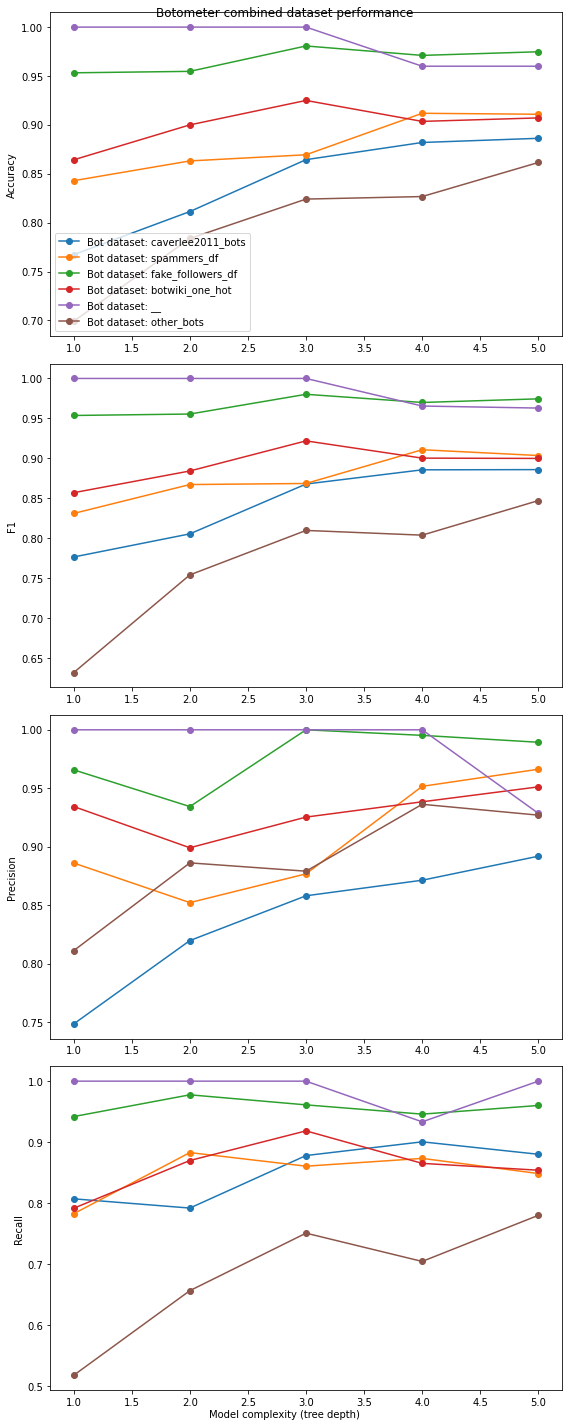

In [167]:
fig, axes = plt.subplots(4, 1, figsize=(8,20))
max_depth = 5

for ind, row in botometer_leave_one_out_scores.iterrows():
    metric_a = [row[f'a{i}'] for i in range(1,max_depth+1)]
    axes[0].plot(range(1,6), metric_a, label=f"Bot dataset: {row['dataset']}", marker="o")
    
    metric_f = [row[f'f{i}'] for i in range(1,max_depth+1)]
    axes[1].plot(range(1,6), metric_f, label=f"{row['dataset']}", marker="o")
    
    metric_p = [row[f'p{i}'] for i in range(1,max_depth+1)]
    axes[2].plot(range(1,6), metric_p, label=f"{row['dataset']}", marker="o")
    
    metric_r = [row[f'r{i}'] for i in range(1,max_depth+1)]
    axes[3].plot(range(1,6), metric_r, label=f"{row['dataset']}", marker="o")
    
    
    axes[0].set_ylabel("Accuracy")
    axes[1].set_ylabel("F1")
    axes[2].set_ylabel("Precision")
    axes[3].set_ylabel("Recall")

axes[0].legend(loc='lower left')
fig.text(0.5, 0.0, 'Model complexity (tree depth)', ha='center')
fig.suptitle("Botometer combined dataset performance")
fig.tight_layout()
plt.show()

# Botometer combined datasets: train on one, test on another

In [174]:
def train_on_one_test_on_another_botometer_combined(bots1, bots2, humans, silent=True):
    dataset_size = min(len(bots1), len(bots2), len(humans))
    bot1_inds = np.random.permutation(dataset_size)
    human1_inds = np.random.permutation(dataset_size)
    
    bot2_inds = np.random.permutation(dataset_size)
    human2_inds = np.random.permutation(dataset_size)
    
    cols = set.intersection(
        set(bots1.columns),
        set(bots2.columns),
        set(humans.columns)
    )
    if 'created_at' in cols:
        cols.remove('created_at')
    
    train_on = pd.concat([bots1.iloc[bot1_inds][cols], humans.iloc[human1_inds][cols]])
    train_on_labels = [1] * dataset_size + [0] * dataset_size
    train_on = train_on[cols].fillna(0)
    
    test_on = pd.concat([bots2.iloc[bot2_inds][cols], humans.iloc[human2_inds][cols]])
    test_on_labels = [1] * dataset_size + [0] * dataset_size
    test_on = test_on[cols].fillna(0)
    
    
    scores = {
        'train_on': get_dataset_name(bots1),
        'test_on': get_dataset_name(bots2),
    }
    
    for i in range(1, max_depth+1):
        clf, *_ = fit_and_score(train_on, train_on_labels, depth=i, silent=silent)
        a,p,r,f = score(clf, test_on, test_on_labels, silent=silent)
        #prop_bots = sum(test_on_labels)/len(test_on_labels)
        scores = {
            **scores, 
            f'a{i}': a,
            f'p{i}': p,
            f'r{i}': r,
            f'f{i}': f
        }
        
    return scores


In [175]:
rows = []

for bots1 in botometer_datasets:
    for bots2 in botometer_datasets:
        if (get_dataset_name(bots1) == get_dataset_name(bots2)):
            continue
        #print(get_dataset_name(bots1), get_dataset_name(bots2))
        rows.append(train_on_one_test_on_another_botometer_combined(bots1, bots2, human_df, silent=True))
        
botometer_train_on_one_test_on_another_performance = pd.DataFrame(rows)   


<ipython-input-174-5e1cea4230bc>:17: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_on = pd.concat([bots1.iloc[bot1_inds][cols], humans.iloc[human1_inds][cols]])
<ipython-input-174-5e1cea4230bc>:17: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_on = pd.concat([bots1.iloc[bot1_inds][cols], humans.iloc[human1_inds][cols]])
<ipython-input-174-5e1cea4230bc>:19: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_on = train_on[cols].fillna(0)
<ipython-input-174-5e1cea4230bc>:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  test_on = pd.concat([bots2.iloc[bot2_inds][cols], humans.iloc[human2_inds][cols]])
<ipython-input-174-5e1cea4230bc>:21: FutureWarning: Passing a set as an indexer is deprecated and will ra

In [182]:
_df = botometer_train_on_one_test_on_another_performance
_df = _df[_df.train_on == "caverlee2011_bots"]

In [186]:
for ind, row in _df.iterrows():
    metric_a = [row[f'a{i}'] for i in range(1,max_depth+1)]
    print(metric_a)
    

[0.5556807636219011, 0.8336868619912502, 0.6360864377568607, 0.6440408325599893, 0.646095717884131]
[0.4501187648456057, 0.8666864608076009, 0.912856294536817, 0.9088479809976246, 0.9456650831353919]
[0.4391117478510029, 0.4391117478510029, 0.47206303724928367, 0.4656160458452722, 0.47206303724928367]
[0.9193548387096774, 0.9193548387096774, 0.9919354838709677, 0.9838709677419355, 1.0]
[0.5106517733763243, 0.47869645324735144, 0.4993666513127591, 0.48514509442653153, 0.496890833717181]


[0.5556807636219011, 0.8336868619912502, 0.6360864377568607, 0.6440408325599893, 0.646095717884131]
[0.4501187648456057, 0.8666864608076009, 0.912856294536817, 0.9088479809976246, 0.9456650831353919]
[0.4391117478510029, 0.4391117478510029, 0.47206303724928367, 0.4656160458452722, 0.47206303724928367]
[0.9193548387096774, 0.9193548387096774, 0.9919354838709677, 0.9838709677419355, 1.0]
[0.5106517733763243, 0.47869645324735144, 0.4993666513127591, 0.48514509442653153, 0.496890833717181]


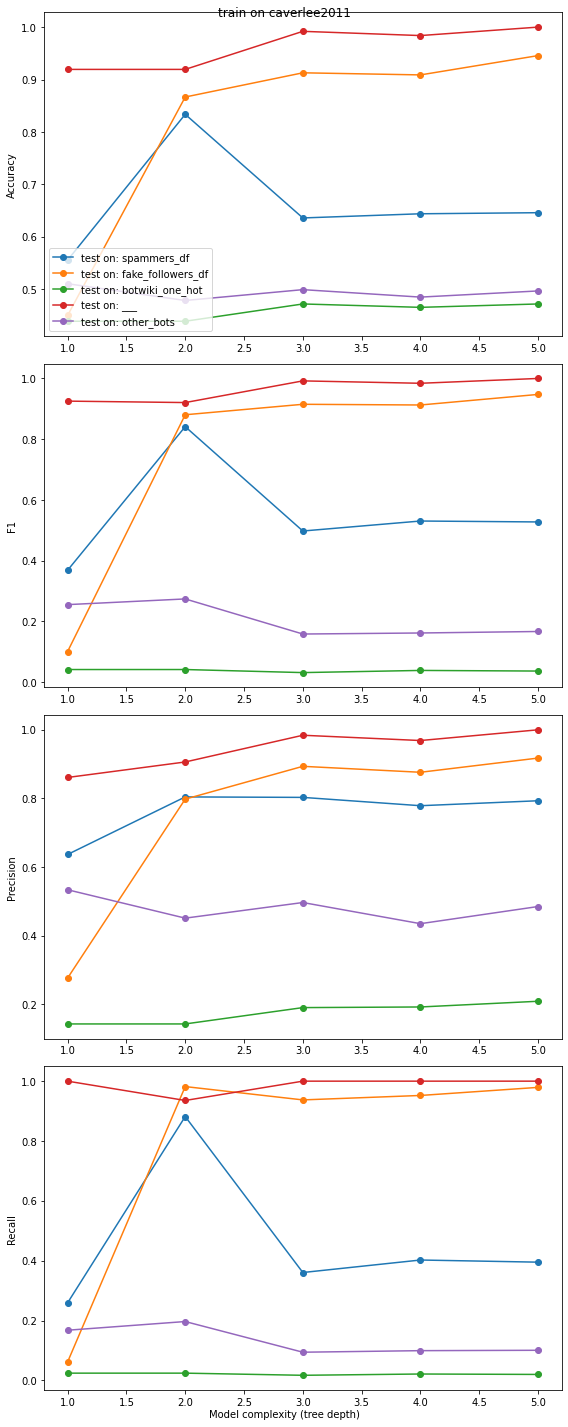

In [188]:
fig, axes = plt.subplots(4, 1, figsize=(8,20))
max_depth = 5

for ind, row in _df.iterrows():
    metric_a = [row[f'a{i}'] for i in range(1,max_depth+1)]
    print(metric_a)
    axes[0].plot(range(1,6), metric_a, label=f"test on: {row['test_on']}", marker="o")
    
    metric_f = [row[f'f{i}'] for i in range(1,max_depth+1)]
    axes[1].plot(range(1,6), metric_f, label=f"test on: {row['test_on']}", marker="o")
    
    metric_p = [row[f'p{i}'] for i in range(1,max_depth+1)]
    axes[2].plot(range(1,6), metric_p, label=f"test on: {row['test_on']}", marker="o")
    
    metric_r = [row[f'r{i}'] for i in range(1,max_depth+1)]
    axes[3].plot(range(1,6), metric_r, label=f"test on: {row['test_on']}", marker="o")
    
    
    axes[0].set_ylabel("Accuracy")
    axes[1].set_ylabel("F1")
    axes[2].set_ylabel("Precision")
    axes[3].set_ylabel("Recall")

axes[0].legend(loc='lower left')
fig.text(0.5, 0.0, 'Model complexity (tree depth)', ha='center')
fig.suptitle("train on caverlee2011")
fig.tight_layout()
plt.show()

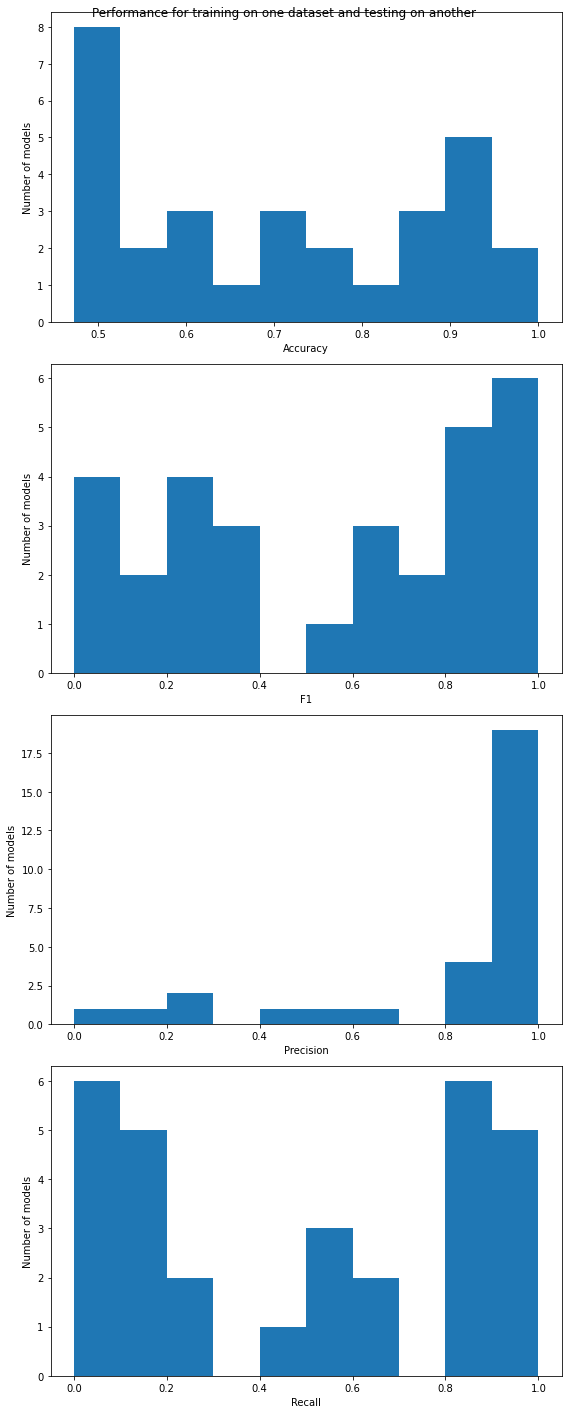

In [89]:
hist_train_on_one_test_on_another(botometer_train_on_one_test_on_another_performance)

# Botometer combined datasets: leave-one-dataset-out

In [154]:
cols = list(set.intersection(*map(set,[list(d) for d in botometer_datasets])))
cols.remove("created_at")
max_depth = 5
n = 1000
def botometer_leave_dataset_out(datasets, i):
    np.random.seed(1)
    use_datasets = datasets[:i] + datasets[i+1:]
    num_bots = sum([len(d) for d in datasets[:i]]) + sum([len(d) for d in datasets[i+1:]])
    
    dataset_size = min(num_bots, len(datasets[i]), len(human_df))
    
    bot_train_inds = np.random.permutation(n)
    human_train_inds = np.random.permutation(n)
    
    bot_test_inds = np.random.permutation(dataset_size)
    human_test_inds = np.random.permutation(dataset_size)
    

    scores = {
        'left_out': get_dataset_name(datasets[i])
    }
    
    train_on_bots = pd.concat([d[cols] for d in use_datasets]).iloc[bot_train_inds]
    train_on = pd.concat([train_on_bots, human_df.iloc[human_train_inds][cols]])
    train_on_labels = [1]*n + [0]*n
    train_on = train_on.fillna(0)

        
    test_on_bots = datasets[i][cols].iloc[bot_test_inds]
    test_on = pd.concat([test_on_bots, human_df.iloc[human_test_inds][cols]])
    test_on_labels = [1]*dataset_size + [0]*dataset_size
    test_on = test_on.fillna(0)

    
    for j in range(1,max_depth+1):
        
        print(j,get_dataset_name(datasets[i]))
        clf, *_ = fit_and_score(train_on, train_on_labels, depth=j, silent=False)
        a,p,r,f = (score(clf, test_on, test_on_labels, silent=True))
        scores = {
            **scores, 
            f'a{j}': a,
            f'p{j}': p,
            f'r{j}': r,
            f'f{j}': f
        }
    return scores


In [132]:
for e in botometer_datasets:
    print(get_dataset_name(e),len(e))

caverlee2011_bots 22223
spammers_df 7543
fake_followers_df 3368
botwiki_one_hot 698
__ 62
other_bots 8684


In [155]:
rows = []

for i in range(len(botometer_datasets)):
    rows.append(botometer_leave_dataset_out(botometer_datasets, i))
    print("\n\n\n")
    
botometer_leave_one_out_scores = pd.DataFrame(rows)

1 caverlee2011_bots
|--- statuses_count <= 553.50
|   |--- weights: [138.00, 840.00] class: 1
|--- statuses_count >  553.50
|   |--- weights: [862.00, 160.00] class: 0

Accuracy: 0.851
Precision 0.8588957055214724
Recall: 0.84
F1: 0.8493427704752275
2 caverlee2011_bots
|--- statuses_count <= 553.50
|   |--- followers_count <= 5.50
|   |   |--- weights: [3.00, 393.00] class: 1
|   |--- followers_count >  5.50
|   |   |--- weights: [135.00, 447.00] class: 1
|--- statuses_count >  553.50
|   |--- friends_count <= 884.00
|   |   |--- weights: [743.00, 38.00] class: 0
|   |--- friends_count >  884.00
|   |   |--- weights: [119.00, 122.00] class: 1

Accuracy: 0.8525
Precision 0.7891714520098442
Recall: 0.962
F1: 0.8670572329878324
3 caverlee2011_bots
|--- statuses_count <= 553.50
|   |--- followers_count <= 5.50
|   |   |--- statuses_count <= 4.00
|   |   |   |--- weights: [2.00, 0.00] class: 0
|   |   |--- statuses_count >  4.00
|   |   |   |--- weights: [1.00, 393.00] class: 1
|   |--- fol

In [125]:
political_bots_df

,followers_count,listed_count,statuses_count,friends_count,favourites_count,created_at,time_zone_Eastern Time (US & Canada),"location_Boston, MA","location_Boston, Masachusetts","location_Boston, Massachusetts",...,"location_Medfield, MAssachusetts","location_Methuen, Massachusetts","location_Sherborn, Massachusetts","location_Springfield, MA",default_profile_True,utc_offset_-10800.0,default_profile_True,profile_background_tile_True,utc_offset_-10800.0,geo_enabled_True
0,1319,9,984,1295,950,1.390769e+09,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1310,12,695,1264,189,1.379193e+09,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1522,12,2012,1504,1115,1.342542e+09,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
3,1251,10,655,1190,319,1.391092e+09,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1349,10,785,1293,265,1.372357e+09,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,1447,11,1863,1445,1103,1.341610e+09,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
58,1407,9,1024,1347,723,1.388622e+09,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
59,925,10,895,930,287,1.344115e+09,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
60,1433,15,1190,1392,769,1.394567e+09,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [101]:
rows = []

i = 3
rows.append(botometer_leave_dataset_out(botometer_datasets, i))
    
botometer_leave_one_out_scores = pd.DataFrame(rows)

|--- friends_count <= 757.00
|   |--- weights: [596.00, 89.00] class: 0
|--- friends_count >  757.00
|   |--- weights: [102.00, 609.00] class: 1

Accuracy: 0.8631805157593123
Precision 0.8565400843881856
Recall: 0.8724928366762178
F1: 0.8644428672817601
|--- friends_count <= 757.00
|   |--- statuses_count <= 373.00
|   |   |--- weights: [54.00, 54.00] class: 0
|   |--- statuses_count >  373.00
|   |   |--- weights: [542.00, 35.00] class: 0
|--- friends_count >  757.00
|   |--- statuses_count <= 6696.50
|   |   |--- weights: [34.00, 519.00] class: 1
|   |--- statuses_count >  6696.50
|   |   |--- weights: [68.00, 90.00] class: 1

Accuracy: 0.8631805157593123
Precision 0.8565400843881856
Recall: 0.8724928366762178
F1: 0.8644428672817601
|--- friends_count <= 757.00
|   |--- statuses_count <= 373.00
|   |   |--- friends_count <= 130.00
|   |   |   |--- weights: [50.00, 9.00] class: 0
|   |   |--- friends_count >  130.00
|   |   |   |--- weights: [4.00, 45.00] class: 1
|   |--- statuses_co

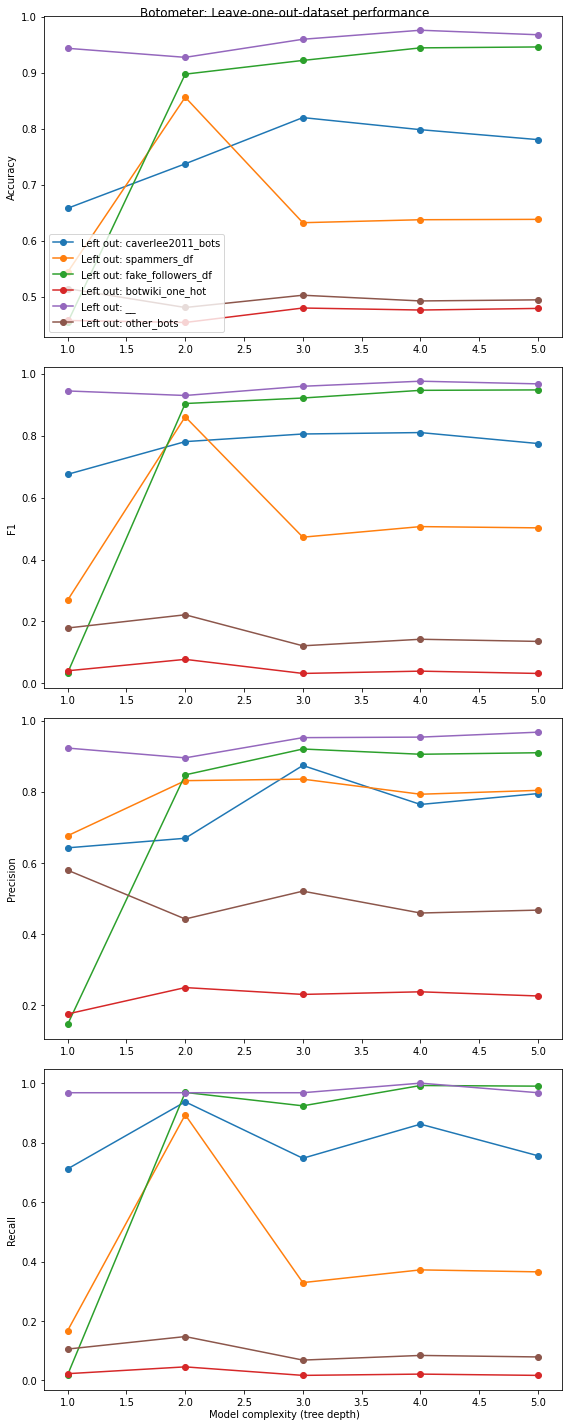

In [156]:
fig, axes = plt.subplots(4, 1, figsize=(8,20))
max_depth = 5

for ind, row in botometer_leave_one_out_scores.iterrows():
    metric_a = [row[f'a{i}'] for i in range(1,max_depth+1)]
    axes[0].plot(range(1,6), metric_a, label=f"Left out: {row['left_out']}", marker="o")
    
    metric_f = [row[f'f{i}'] for i in range(1,max_depth+1)]
    axes[1].plot(range(1,6), metric_f, label=f"Left out: {row['left_out']}", marker="o")
    
    metric_p = [row[f'p{i}'] for i in range(1,max_depth+1)]
    axes[2].plot(range(1,6), metric_p, label=f"Left out: {row['left_out']}", marker="o")
    
    metric_r = [row[f'r{i}'] for i in range(1,max_depth+1)]
    axes[3].plot(range(1,6), metric_r, label=f"Left out: {row['left_out']}", marker="o")
    
    
    axes[0].set_ylabel("Accuracy")
    axes[1].set_ylabel("F1")
    axes[2].set_ylabel("Precision")
    axes[3].set_ylabel("Recall")

axes[0].legend(loc='lower left')
fig.text(0.5, 0.0, 'Model complexity (tree depth)', ha='center')
fig.suptitle("Botometer: Leave-one-out-dataset performance")
fig.tight_layout()
plt.show()

# Plotting performance of network stats on single plot

In [104]:
scores_dict = {
    "twibot": {
        'c': 'C0',
        "a": 0.8664, #accuracy
        "p": 0.8256, #precision
        "r": 0.8657, #recall
        'scores': twibot_scores
    },
    "botometer-feedback-2019": {
        'c': 'C1',
        'a': 0.81,
        "p": 0.84,
        "r": 0.7,
        'num_bots': 139,
        'num_humans': 380,
        'scores': botometer_feedback_scores
    },
    "rtbust": {
        'c': 'C2',        
        "a": 0.8755,
        'p': 0.9304,
        'r': 0.9512,
        'scores': rtbust_scores
    },
    "midterm-2018": {
        'c': 'C3',
        "a": 0.987,
        'p': 0.989,
        'r': 0.995,
        'scores': midterm_scores
    },
    "gilani": {
        'c': 'C4',
        "a": 0.8644,
        'p': 0.854,
        'r': 0.822,
        'scores': gilani_derived_scores_avg
    },
    "cresci-2017": {
        'c': 'C5',
        'a': 0.9871,
        'p': 0.98,
        'r': 0.98,
        'scores': cresci2017_scores
    },
    "cresci-2015": {
        'c': 'C6',
        "a": 0.991,
        'p': 0.994,
        'r': 0.991,
        'scores': cresci2015_scores
    },
    "caverlee-2011": {
        'c': 'C6',
        'a': 0.9826,
        'p': 0.89,
        'r': 0.87,
        'num_bots': 19276,
        'num_humans': 22223,
        'scores': caverlee2011_scores
    },
    'pan19': {
        'c': 'C7',
        'f': 0.95,
        'a': 0.95,
        'scores': pan19_scores
    },
    'cresci-2017 tweets': {
        'c': 'C8',
        'a': 0.976,
        'p': 1,
        'r': 0.95,
        'scores': pan19_scores
    },
    'yang-2013': {
        'c': 'C9',
        'a': 0.98,
        'p': 0.96,
        'r': 0.85,
        'scores': yang_scores
    }
}
metric_names = ['accuracy', 'F1', 'precision', 'recall']

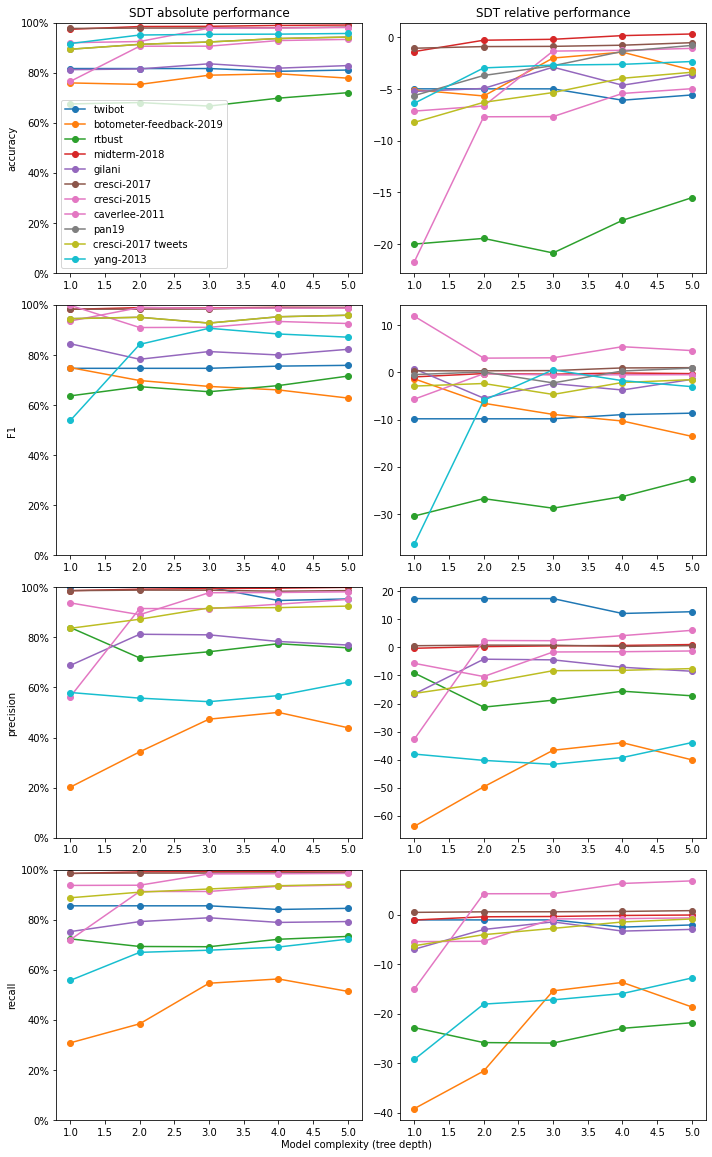

In [105]:
fig, axes = plt.subplots(4,2, figsize=(10, 16))

for i, metric_name in enumerate(metric_names):
    for name, d in scores_dict.items():
        if i == 0:
            if 'a' not in d:
                continue
            soa_score = d['a']
        if i == 1:
            if 'f' not in d:
                d['f'] = 2 * (d['p'] * d['r']) / (d['p'] + d['r'])
            soa_score = d['f']
        if i == 2:
            if 'p' not in d:
                continue
            soa_score = d['p']
        if i == 3:
            if 'r' not in d:
                continue
            soa_score = d['r']
        metric_i = [item[i]*100 for item in d['scores']]
        axes[i][0].plot(range(1,6), metric_i, label=name, marker="o", color=d['c'])
        metric_i_relative = [(item[i]-soa_score)*100 for item in d['scores']]
        axes[i][1].plot(range(1,6), metric_i_relative, label=name, marker="o", color=d['c'])
        metric_i_max = max([item[i] for item in d['scores']])
        delta_i = metric_i_max - soa_score
        d["sdt_"+metric_name] = metric_i_max
        d["sdt_delta_"+metric_name] = delta_i
    axes[i][0].set_ylabel(metric_name)
    axes[i][0].set_ylim((0,100))
    yticks = mtick.PercentFormatter(is_latex=True)
    axes[i][0].yaxis.set_major_formatter(yticks)
axes[0][0].legend(loc='lower left')
fig.text(0.5, 0.0, 'Model complexity (tree depth)', ha='center')
axes[0][0].set_title("SDT absolute performance")
axes[0][1].set_title("SDT relative performance")
fig.tight_layout()
plt.show()

score_df = pd.DataFrame.from_dict(scores_dict, orient="index")
score_df.to_csv("bot_detection_scores.csv")

In [106]:
score_df

,c,a,p,r,scores,sdt_accuracy,sdt_delta_accuracy,f,sdt_F1,sdt_delta_F1,sdt_precision,sdt_delta_precision,sdt_recall,sdt_delta_recall,num_bots,num_humans
twibot,C0,0.8664,0.8256,0.8657,"[(0.8165680473372781, 0.7467911318553092, 1.0,...",0.816568,-0.049832,0.845175,0.758706,-0.086468,1.000000,0.174400,0.855043,-0.010657,NaN,NaN
botometer-feedback-2019,C1,0.8100,0.8400,0.7000,"[[0.7592046303211353, 0.7496732026143791, 0.20...",0.795743,-0.014257,0.763636,0.749673,-0.013963,0.500229,-0.339771,0.563034,-0.136966,139.0,380.0
rtbust,C2,0.8755,0.9304,0.9512,"[[0.6753347686814053, 0.6368232919629185, 0.83...",0.720233,-0.155267,0.940685,0.715711,-0.224974,0.839099,-0.091301,0.732820,-0.218380,NaN,NaN
midterm-2018,C3,0.9870,0.9890,0.9950,"[(0.9732884843688168, 0.9821847163619315, 0.98...",0.990305,0.003305,0.991991,0.990406,-0.001585,0.999408,0.010408,0.994229,-0.000771,NaN,NaN
gilani,C4,0.8644,0.8540,0.8220,"[[0.8120704261457423, 0.8449418148178527, 0.68...",0.835580,-0.028820,0.837695,0.844942,0.007247,0.812139,-0.041861,0.807343,-0.014657,NaN,NaN
cresci-2017,C5,0.9871,0.9800,0.9800,"[[0.976614755671344, 0.9829805884415613, 0.986...",0.981974,-0.005126,0.980000,0.989687,0.009687,0.988337,0.008337,0.988094,0.008094,NaN,NaN
cresci-2015,C6,0.9910,0.9940,0.9910,"[[0.9196306299638779, 0.9356570480014884, 0.93...",0.980382,-0.010618,0.992498,0.989365,-0.003132,0.981513,-0.012487,0.984440,-0.006560,NaN,NaN
caverlee-2011,C6,0.9826,0.8900,0.8700,"[[0.7653680004994069, 0.9981723488283671, 0.56...",0.932914,-0.049686,0.879886,0.998172,0.118286,0.951077,0.061077,0.938195,0.068195,19276.0,22223.0
pan19,C7,0.9500,NaN,NaN,"[[0.8936910569105692, 0.9451030878283099, 0.83...",0.942235,-0.007765,0.950000,0.958715,0.008715,NaN,NaN,NaN,NaN,NaN,NaN
cresci-2017 tweets,C8,0.9760,1.0000,0.9500,"[[0.8936910569105692, 0.9451030878283099, 0.83...",0.942235,-0.033765,0.974359,0.958715,-0.015644,0.924609,-0.075391,0.941232,-0.008768,NaN,NaN


In [107]:
score_df = pd.read_csv('bot_detection_scores.csv')

In [108]:
score_df[['Unnamed: 0', 'sdt_delta_F1']]

,Unnamed: 0,sdt_delta_F1
0,twibot,-0.086468
1,botometer-feedback-2019,-0.013963
2,rtbust,-0.224974
3,midterm-2018,-0.001585
4,gilani,0.007247
5,cresci-2017,0.009687
6,cresci-2015,-0.003132
7,caverlee-2011,0.118286
8,pan19,0.008715
9,cresci-2017 tweets,-0.015644


In [109]:
score_df['sdt_delta_F1']

0    -0.086468
1    -0.013963
2    -0.224974
3    -0.001585
4     0.007247
5     0.009687
6    -0.003132
7     0.118286
8     0.008715
9    -0.015644
10    0.005088
Name: sdt_delta_F1, dtype: float64